In [2]:
import os
import cv2
import json
import numpy as np
import pandas
import skimage
import shapefile
import matplotlib.pyplot as plt

import time
from PIL import Image as pil_image

from keras.applications import resnet_v2, vgg16
from keras import backend as K
from keras import layers
from keras.preprocessing.image import save_img
from keras.models import load_model

import modules

Using TensorFlow backend.


In [6]:
resnet = resnet_v2.ResNet50V2(include_top=True, weights='imagenet')

#resnet = load_model('model_filename.h5')

LAYER_NAME = 'conv1_conv'

print('Model loaded.')

print(resnet.summary())

Model loaded.
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________

In [24]:
def normalize(x):
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()

# Learns input image that maximizes filter activation

def visualize_layer_filter(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_index=0):
    
    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):

        # Loss function that maximizes the activation of the nth filter of the layer considered
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])
        
        # NOTE: Replacing the below with the output index of the desired class (e.g. '2' for 'two-track')
        # can allow you to generate visualization of filters that maximize the activation for the given
        # output class (e.g. will generate an image that looks like what the model thinks is a two-track road)
        
        # output_index = 5
        # loss = K.mean(model.output[:, output_index])

        grads = normalize(K.gradients(loss, input_img)[0])
        
        # returns the loss and grads given input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    return None

            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = np.expand_dims(
                process_image(img, input_img_data[0]), 0)

        img = deprocess_image(input_img_data[0])

        return img, loss_value

    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    img_loss = _generate_filter_image(input_img, output_layer.output, filter_index)
    return img_loss


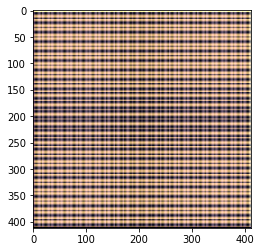

In [25]:
# Example: Visualization of input image that maximizes activation of filter #5 in conv1_conv layer (as defined by LAYER_NAME above)
plt.imshow(visualize_layer_filter(resnet, LAYER_NAME, filter_index=5)[0])

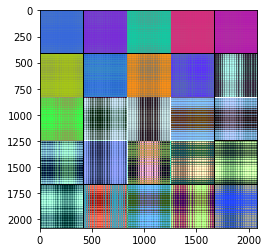

In [14]:
# Example plot of several other filters from the first CONV layer
plt.imshow(cv2.imread('vgg_conv1_conv_5x5.png'))

In [9]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from keras.applications.resnet_v2 import preprocess_input
from keras.models import Model
from matplotlib import pyplot

In [10]:
# Generates activation map of each filter in 'layer_name' applied to 'img'

def show_activation_map(img, model, layer_name, preprocess_fn, square_dim):

    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


    model = Model(inputs=model.inputs, outputs=layer_dict[layer_name].output)

    img = img_to_array(img)
    img = expand_dims(img, axis=0)
    img = preprocess_fn(img)
    feature_maps = model.predict(img)

    img = np.clip(img, 0, 1)
    pyplot.imshow(img[0, :,:,:])
    pyplot.show()
    
    ix = 1
    for _ in range(square_dim):
        for _ in range(square_dim):
            ax = pyplot.subplot(square_dim, square_dim, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='magma')
            ix += 1
    pyplot.show()

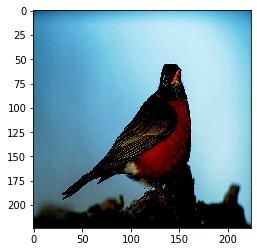

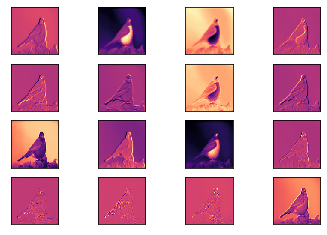

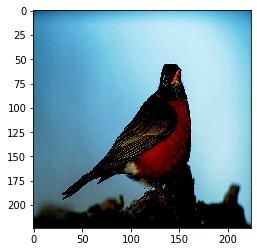

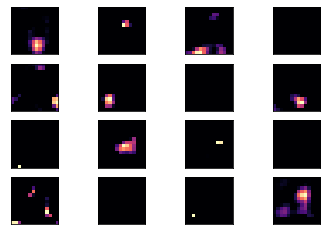

In [18]:
img = load_img('bird.jpg', target_size=(224, 224))

# Note: 'square_dim' can be up to the square root of the number of filters in the layer

# First CONV layer activation map
show_activation_map(img, resnet, 'conv1_conv', preprocess_input, square_dim=4)

# Class activation map
#vgg = vgg16.VGG16(include_top=True, weights='imagenet')
show_activation_map(img, vgg, 'block5_conv3', preprocess_input, square_dim=4)

In [ ]:
# Generates test set indices for failure case analysis

def get_failure_indices(X_test, y_test):
    return np.nonzero(model.predict_class(X_test).reshape((-1,)) != y_test)